In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna

from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
df1 = pd.read_csv("data/야수_전처리_ver13.csv")
df2 = pd.read_csv("data/26년FA_야수_ver2.csv")

In [3]:
# 계약금 컬럼 생성
df1['FA 계약 총액'] = df1['FA 계약 총액'].fillna(0)
df1['연봉'] = df1['연봉'].fillna(0)
df1['계약금'] = df1['FA 계약 총액'] + df1['연봉']

In [4]:
# 전처리 함수 정의
def preprocess(df):
    df = df.copy()
    if '구분' in df.columns:
        df = df[~df['구분'].isin(['해외', 'FA 1년차'])]
    if 'FA등급' in df.columns:
        df = df[~df['FA등급'].isin(['해외', 'FA 1년차'])]
    if '플레이년도' in df.columns:
        df = df[df['플레이년도'] > 2015]

    drop_cols = ['선수명_수정', 'FA 계약 총액', '연봉', '잔류여부']
    df = df.drop(columns=[col for col in drop_cols if col in df.columns], errors='ignore')
    df = df.groupby('선수명', as_index=False).mean(numeric_only=True)
    return df

df1_cleaned = preprocess(df1)
df2_cleaned = preprocess(df2)

C:\Users\Lee\AppData\Local\Temp\ipykernel_22684\3216511609.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlations.values, y=correlations.index, palette='Blues_d')


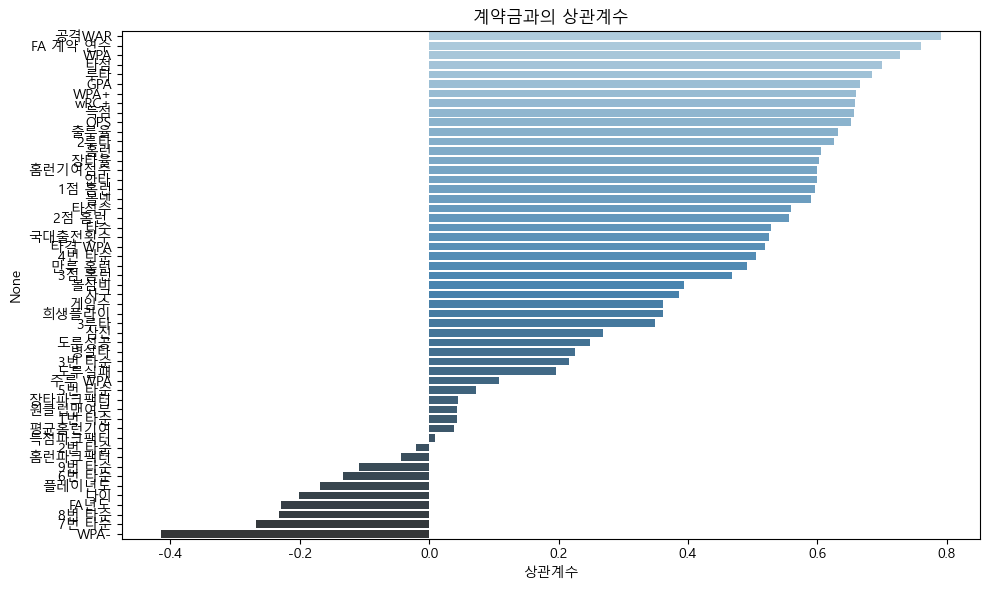

In [5]:
# 상관계수 및 가중치 계산
correlations = df1_cleaned.corr(numeric_only=True)['계약금'].drop('계약금').sort_values(ascending=False)
weights = correlations.abs() / correlations.abs().sum()
weight_df = pd.DataFrame({'컬럼명': weights.index, '가중치': weights.values})

# 시각화
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
plt.figure(figsize=(10, 6))
sns.barplot(x=correlations.values, y=correlations.index, palette='Blues_d')
plt.title('계약금과의 상관계수')
plt.xlabel('상관계수')
plt.tight_layout()
plt.show()

In [6]:
# 예측에 사용할 피처 선택
predict_features = [f for f in weights.index if f in df1_cleaned.columns and f in df2_cleaned.columns]
X = df1_cleaned[predict_features]
y = df1_cleaned['계약금']
Xy = pd.concat([X, y], axis=1).dropna()
X = Xy[predict_features]
y = Xy['계약금']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_test = df2_cleaned[predict_features]

In [7]:
# Optuna로 하이퍼파라미터 튜닝 
def objective(trial):
    params = {
        'iterations': trial.suggest_categorical('iterations', [300, 500, 700]),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'random_strength': trial.suggest_float('random_strength', 1, 10),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1),
        'verbose': 0,
        'random_seed': 42
    }
    model = CatBoostRegressor(**params)
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error').mean()
    return -score

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)

[I 2025-08-06 14:29:59,140] A new study created in memory with name: no-name-9f9332f8-ed7b-4354-ae72-aecc2153518b
[I 2025-08-06 14:30:00,459] Trial 0 finished with value: 118103.53406980532 and parameters: {'iterations': 300, 'depth': 6, 'learning_rate': 0.010456386876446096, 'l2_leaf_reg': 1.5126854779017247, 'random_strength': 4.643837694035863, 'bagging_temperature': 0.20182127786688386}. Best is trial 0 with value: 118103.53406980532.
[I 2025-08-06 14:30:04,317] Trial 1 finished with value: 109445.50945697457 and parameters: {'iterations': 700, 'depth': 7, 'learning_rate': 0.23199496556470098, 'l2_leaf_reg': 7.625412281854947, 'random_strength': 6.454582429092222, 'bagging_temperature': 0.4261615835063165}. Best is trial 1 with value: 109445.50945697457.
[I 2025-08-06 14:30:16,897] Trial 2 finished with value: 128623.06240186747 and parameters: {'iterations': 500, 'depth': 10, 'learning_rate': 0.012490074583367348, 'l2_leaf_reg': 9.169709037739347, 'random_strength': 3.063128946488

In [8]:
# 최적 모델 학습 및 검증
best_params = study.best_params
best_model = CatBoostRegressor(**best_params)
best_model.fit(X_train, y_train)

val_pred = best_model.predict(X_val)

mse = mean_squared_error(y_val, val_pred)  
rmse = mean_squared_error(y_val, val_pred, squared=False)
mae = mean_absolute_error(y_val, val_pred)
r2 = r2_score(y_val, val_pred)

print(f"[모델 평가 지표]")
print(f" MSE : {mse:,.2f}")
print(f" RMSE: {rmse:,.2f}")
print(f" MAE : {mae:,.2f}")
print(f" R²  : {r2:.4f}")

print("[CatBoost + Optuna] 최적 파라미터:")
print(best_params)

0:	learn: 167569.5268351	total: 1.69ms	remaining: 1.18s
1:	learn: 165678.1267419	total: 3.44ms	remaining: 1.2s
2:	learn: 163876.0444848	total: 4.58ms	remaining: 1.06s
3:	learn: 161151.6351893	total: 6.06ms	remaining: 1.05s
4:	learn: 158782.6711943	total: 7.48ms	remaining: 1.04s
5:	learn: 156877.4119651	total: 8.84ms	remaining: 1.02s
6:	learn: 154846.3952038	total: 9.9ms	remaining: 980ms
7:	learn: 153482.9446731	total: 11ms	remaining: 952ms
8:	learn: 150614.8758234	total: 12.3ms	remaining: 946ms
9:	learn: 148833.4259069	total: 13.5ms	remaining: 934ms
10:	learn: 147324.2282055	total: 14.6ms	remaining: 913ms
11:	learn: 145223.0878771	total: 15.6ms	remaining: 895ms
12:	learn: 143788.3171870	total: 16.7ms	remaining: 880ms
13:	learn: 142321.1471338	total: 18ms	remaining: 884ms
14:	learn: 140522.2032130	total: 19.1ms	remaining: 874ms
15:	learn: 139020.8194042	total: 20.2ms	remaining: 862ms
16:	learn: 137104.1092953	total: 21.3ms	remaining: 856ms
17:	learn: 135564.4860369	total: 22.4ms	remaini

C:\Users\Lee\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [9]:
# 계약금 예측 및 반올림
df2_cleaned['계약금'] = best_model.predict(X_test).round(0).astype(int)

피처 중요도 (CatBoost + Optuna):
       컬럼명  중요도 (CatBoost)  상관계수 기반 가중치
19  국대출전횟수        9.572088     0.024811
9      출루율        4.902217     0.029911
45      나이        4.492864     0.009510
8      OPS        4.429228     0.030850
24     볼삼비        3.111099     0.018640
5     WPA+        3.073573     0.031188
10     2루타        2.784821     0.029629
6     wRC+        2.781460     0.031113
0    공격WAR        2.768228     0.037415
25      사구        2.757704     0.018232
1      WPA        2.730557     0.034405
28     3루타        2.642807     0.016514
3       루타        2.528255     0.032392
37  원클럽맨여부        2.505620     0.002069
7       득점        2.342491     0.031086
33    도루실패        2.320654     0.009282
43   6번 타순        2.207604     0.006285
17     타석수        2.203425     0.026472
23   3점 홈런        2.156900     0.022117
4      GPA        2.126673     0.031468
30    도루성공        2.126113     0.011745
31     병살타        1.685224     0.010658
36  장타파크팩터        1.600580     0.002134
18      타수  

C:\Users\Lee\AppData\Local\Temp\ipykernel_22684\406754386.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df, y='컬럼명', x='중요도 (CatBoost)', palette='PuBuGn')


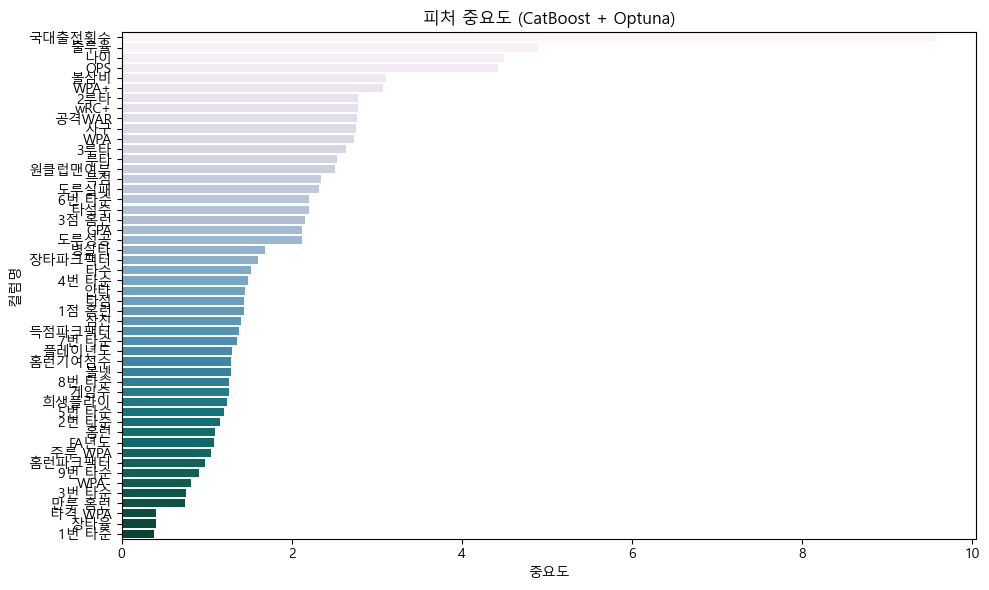

In [10]:
# 피처 중요도 분석
importance_df = pd.DataFrame({
    '컬럼명': predict_features,
    '중요도 (CatBoost)': best_model.feature_importances_,
    '상관계수 기반 가중치': [weights[f] for f in predict_features]
}).sort_values(by='중요도 (CatBoost)', ascending=False)

print("피처 중요도 (CatBoost + Optuna):")
print(importance_df)

plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df, y='컬럼명', x='중요도 (CatBoost)', palette='PuBuGn')
plt.title('피처 중요도 (CatBoost + Optuna)')
plt.xlabel('중요도')
plt.tight_layout()
plt.show()

In [11]:
# 예측 결과 출력
print("예측 계약금 상위 선수 (CatBoost + Optuna):")
print(df2_cleaned[['선수명', '계약금']].sort_values(by='선수명', ascending=True))

예측 계약금 상위 선수 (CatBoost + Optuna):
    선수명     계약금
0   강민호  203128
1   강백호  146891
2   김재환  201944
3   박병호  206245
4   박승욱   49227
5   박찬호  208511
6   박해민  201283
7   손아섭  163333
8   이재원   65329
9   장성우  118891
10   정훈   47200
11  조수행   70522
12  최원준  144468
13  최형우  218469
14  황재균  138712
